In [68]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.dummy
import sklearn.metrics
import sklearn.neural_network
import sklearn.ensemble

Fetch the data frames from the files

In [ ]:
# read both the matches and the frames
training_df = pd.read_csv('../data/processed/diff_train.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
test_df = pd.read_csv('../data/processed/diff_test.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
# Reinterpret all values as int32s
training_df = training_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})
test_df = test_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})



Helper functions to format the data prior to training

In [84]:

def plot_data(X, y):
    """Plots the data from Exercise 1"""
    plt.scatter(*X[y==-1].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect('equal')  

def plot_rf_prediction(model):
    """
    Plots the model's predictions over all points in range 2D [-3, 3].
    Assumes at most 3 classes.
    """
    extent = (0, 1, 0, 1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.predict(X).reshape(x1.shape)
    cmap = matplotlib.colors.ListedColormap(['r', 'b', 'g'])
    plt.imshow(y, extent=extent, origin='lower', alpha=0.4, vmin=0, vmax=2, cmap=cmap, interpolation='nearest')
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.gca().set_aspect('equal')

def scale_data(X_trn, X_tst):
    # Scale the data with MinMax to avoid negative values
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    return X_trn, X_tst

def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    scores = [0 for _ in range(len(estimators))]
    for x in range(len(estimators)):
        scores[x] = sklearn.metrics.accuracy_score(y, estimators[x].predict(X))
        print(sklearn.metrics.precision_recall_fscore_support(y, estimators[x].predict(X), average='binary'))
    return scores

def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need
    plt.figure()
    X = np.arange(0, len(param_vals))
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    index = np.argmin(trn_scores - tst_scores)
    print(tst_scores[index])
    plt.title(estimators[0].__class__.__name__ + " score vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.scatter(X[index], tst_scores[index], marker='x', color='black', s=200)
    plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.text(0, 0.4,
             "Optimal Test Accuracy = %.2f%% with %s = %d " % (tst_scores[index] * 100, param_name, param_vals[index]))
    plt.legend()
    plt.xticks(X, param_vals)
    

def train_estimators(X, y, estimator, param_grid, cv=3):
    gscv = sklearn.model_selection.GridSearchCV(estimator, param_grid=param_grid, verbose=1, cv=3)
    gscv.fit(X, y)
    print(gscv.cv_results_)
    return gscv


Feature selection: Select an X and y we want to train on

In [ ]:
X_trn = training_df[['kill_advantage','gold_advantage']].values
y_trn = training_df[['winner']].values.T[0]
X_tst = test_df[['kill_advantage','gold_advantage']].values
y_tst = test_df[['winner']].values.T[0]

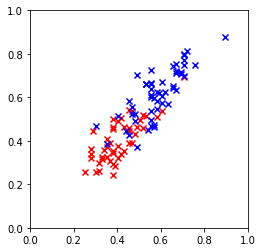

In [97]:
plot_data(X_tst[:100], y_tst[:100])

## Dummy Classifier

In [ ]:

## Here we train a dummy classifier to compare performance
def train_dummy_classifier(X, y):
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='uniform', random_state=0)
    # Scale the data with MinMax to avoid negative values
    dummy_clf.fit(X, y)
    return dummy_clf


## kNN 

In [87]:
def train_kNN_estimators(X, y):
    param_grid = {
        'n_neighbors': [1, 5, 10, 15, 20]
    }
    clf = sklearn.neighbors.KNeighborsClassifier()
    knn_estimators = train_estimators(X, y, estimator=clf, param_grid=param_grid)
    return knn_estimators.best_estimator_
    plot_estimator_scores(knn_estimators, param_name='n_neighbors', param_vals=param_vals)


## Random Forests

In [88]:
def train_random_forests(X, y):
    estimator = np.arange(1, 5) * 50
    depths = np.arange(1, 5) * 5
    param_grid = {
        'n_estimators': estimator, 
        'max_depth': depths
    }
    clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
    gscv = train_estimators(X, y, estimator=clf, param_grid=param_grid)
    return gscv.best_estimator_

## Neural Network

In [89]:
## This is the neural network trained in Lab 8

def train_neural_network(X, y):
    net = sklearn.neural_network.MLPClassifier(        
        learning_rate_init=0.01,
        momentum=0.9,
        random_state=0,
        verbose=True
    )
    param_grid = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
             (), (1,),(2,),(3,),
            ]
        }
    ]
    gscv = train_estimators(X, y, estimator=net, param_grid=param_grid)
    return gscv.best_estimator_
# train_neural_network(X_trn,y_trn)

## Evaluation

In [90]:

X_trn, X_tst = scale_data(X_trn, X_tst)
# train_neural_network(X, y)
knn_clf = train_kNN_estimators(X_trn, y_trn)
# rf_clf = train_random_forests(X_trn, y_trn)

# dm_clf = train_dummy_classifier(X_trn, y_trn)
# y_pred = dm_clf.predict(X_tst)
# stats = sklearn.metrics.precision_recall_fscore_support(y_tst, y_pred, average='binary')
# sklearn.metrics.accuracy_score(y_tst, y_pred)
# plt.figure()
# plot_data(X_trn[:300], y_trn[:300])
# plot_rf_prediction(rf_clf)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'mean_fit_time': array([0.00327881, 0.00323129, 0.00323971, 0.00284696, 0.0027895 ]), 'std_fit_time': array([1.18188675e-04, 3.67521189e-04, 2.39468673e-04, 6.43476978e-05,
       5.87884331e-05]), 'mean_score_time': array([0.14766606, 0.14873894, 0.13362463, 0.13276974, 0.13160531]), 'std_score_time': array([0.01309867, 0.02248362, 0.01085071, 0.00375526, 0.00037589]), 'param_n_neighbors': masked_array(data=[1, 5, 10, 15, 20],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 1}, {'n_neighbors': 5}, {'n_neighbors': 10}, {'n_neighbors': 15}, {'n_neighbors': 20}], 'split0_test_score': array([0.74210828, 0.79510235, 0.80352018, 0.80734647, 0.81212933]), 'split1_test_score': array([0.75741343, 0.80409413, 0.8077291 , 0.81365984, 0.81595562]), 'split2_test_score': array([0.76042863, 0.81419824, 0.82835821, 0.83008037, 0.83199388]), 'mean_test_score'

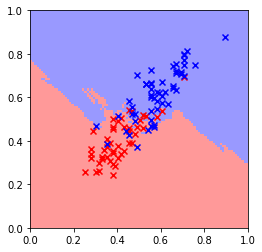

In [96]:
plt.figure()
plot_rf_prediction(knn_clf)
plot_data(X_tst[:100], y_tst[:100])